# Welcome to the 3D Association Workshop!
Here, you will learn how to associate the bounding boxes between 2 consecutive timeframes. We're using Tracking as the main use case, but this can also be 2 different LiDARs returning boxes from 2 different viewpoints.


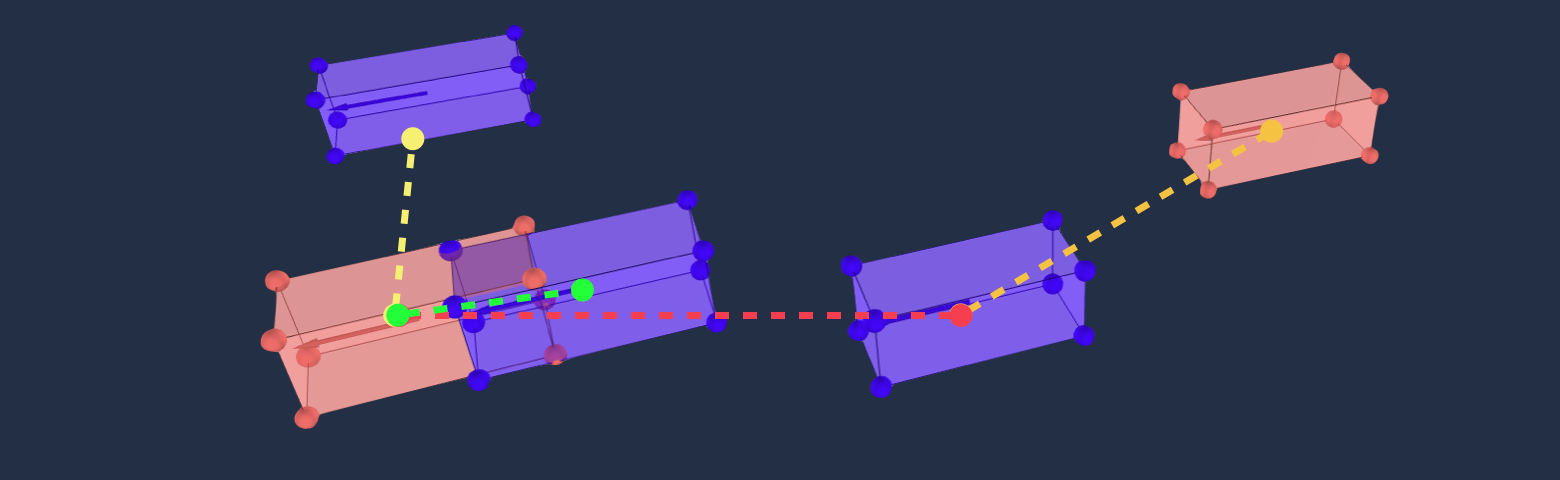

When we're working with 2D Objects, we want to match bounding boxes altogether, and we do that using the Intersection Over Union, or the appearence cost, or the bounding boxes shapes, or any other cost. I cover these in my course [MASTER OBSTACLE TRACKING](https://courses.thinkautonomous.ai/obstacle-tracking).
<p>
In 3D, we'll use several costs:

* The 3D IOU
* The Geometric Cost
* The Appearence
* The Motion Cost

## **Introduction**: Data Download & Colab Setup (5 min)

In [ ]:
!wget https://thinkautonomous-3d-tracking.s3.us-west-2.amazonaws.com/viewer.zip && unzip -q viewer.zip
!wget https://thinkautonomous-3d-tracking.s3.us-west-2.amazonaws.com/data.zip && unzip -q data.zip
!sudo apt-get install libgl1-mesa-dev libgl1-mesa-glx  xvfb -qq
!pip install git+https://github.com/Jeremy26/vedo-mot.git
!pip install ipyvtklink -q
!pip install numpy==1.23.5
!pip install vtk==9.2.6
!pip install open3d #will be used later
exit()

**HERE, RESTART THE SESSION with RUNTIME> RESTART SESSION** <p>
You won't need to re-run the previous cells.

In [ ]:
!wget https://thinkautonomous-3d-tracking.s3.us-west-2.amazonaws.com/multi_object_tracking.zip && unzip -q multi_object_tracking.zip

In [ ]:
!mv data multi_object_tracking/data
!mv viewer multi_object_tracking/viewer

### Imports

In [ ]:
# Activate virtual display (headless display)
import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

In [ ]:
import time
import tqdm
import os
import numpy as np
import argparse
from pathlib import Path
import yaml
from easydict import EasyDict
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import cv2
import shutil

In [ ]:
#from multi_object_tracking.dataset.kitti_dataset import KittiTrackingDataset
from multi_object_tracking.dataset.kitti_data_base import velo_to_cam

from vedo import *

#from multi_object_tracking.dataset.view_kitti_dataset import ViewKittiTrackingDataset
from multi_object_tracking.viewer.viewer import Viewer
from multi_object_tracking.viewer.utils import *
from multi_object_tracking.dataset.kitti_data_base import *
import re

## **Part 1**: Load & Visualize Sequences & Point Clouds


In [ ]:
def view_images(images_to_be_shown):
  _, axs = plt.subplots(1, len(images_to_be_shown), figsize=(20, 40))
  axs = axs.flatten()
  for img, ax in zip(images_to_be_shown, axs):
      img_data = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
      ax.imshow(img_data)
  plt.show()

**Note:** In this notebook, we won't use any object detector, but directly the label, so we create a very similar dataset function, but we skip the DatasetTemplate, and we don't return a dictionnary (it was needed for Point-RCNN but not anymore).

In [ ]:
class KittiDetectionDataset:
    def __init__(self,root_path,seq_id, label_path = None):
        self.seq_name = str(seq_id).zfill(4)
        self.root_path = root_path
        self.velo_path = os.path.join(self.root_path,"velodyne", self.seq_name)
        self.image_path = os.path.join(self.root_path,"image_02", self.seq_name)
        self.calib_path = os.path.join(self.root_path,"calib")
        self.label_path = label_path
        self.all_ids = os.listdir(self.velo_path)

    def __len__(self):
        return len(self.all_ids)

    def __getitem__(self, item):
        name = str(item).zfill(6)
        velo_path = os.path.join(self.velo_path,name+'.bin')
        image_path = os.path.join(self.image_path, name+'.png')
        calib_path = os.path.join(self.calib_path, self.seq_name+'.txt')
        label_path = os.path.join(self.label_path, self.seq_name, name+'.txt')

        P2,V2C = read_calib(calib_path)
        points = read_velodyne(velo_path,P2,V2C)
        image = read_image(image_path)
        objects, det_scores = self.read_detection_label_3(label_path)
        objects[:,3:6] = cam_to_velo(objects[:,3:6],V2C)[:,:3]

        return P2,V2C,points,image,objects,det_scores

    def read_detection_label_3(self,ob_path):
        objects_list = []
        det_scores = []
        with open(ob_path) as f:
            for each_ob in f.readlines():
                infos = re.split(' ', each_ob)
                if infos[0] in ['Car', 'Truck']:
                    objects_list.append(infos[8:15])
                    det_scores.append(infos[15])
        if len(objects_list)!=0:
            objects = np.array(objects_list,np.float32)
            det_scores = np.array(det_scores,np.float32)

        return objects, det_scores

We're now going to create a **Dataset** object that will have these values:
* P2: The intrinsic camera calibration matrix
* V2C: The Velodyne (LiDAR) to Camera projection matrix
* Points: The Point Cloud
* Image: The Image
* Objects: The 3D Bounding Boxes
* Scores: The Scores

Because we "need" a label, we'll load one from the *multi_object_tracking/detector* folder, please disregard this for now as it is not used.

In [ ]:
root = "multi_object_tracking/data"
label_path = "multi_object_tracking/detectors/point_rcnn"
dataset = KittiDetectionDataset(root,seq_id=8,label_path=label_path)

**First, visualize the images alone**

In [ ]:
#If you need to restart the visualizer, remove the frames stored
shutil.rmtree('frames', ignore_errors=True)
shutil.rmtree("3dframes", ignore_errors= True)

### Just visualize Raw Data
hand_picked_frames = [0,1]
settings.default_backend = '2d_image'
settings.default_image_path_for_2d_backend = '3dframes'

In [ ]:
print(dataset[0][2])

Now the visualization loop. You can find ideas for colormap [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

In [ ]:
for i in hand_picked_frames:
    P2, V2C, points, image, labels, scores = dataset[i]
    vi = Viewer(box_type="Kitti") # this is needed for every frame for 2D Visualization
    vi.add_points(points[:,0:3],
                radius = 2,
                color = (150,150,150),
                scatter_filed = points[:,2],
                alpha=1,
                del_after_show = True,
                add_to_3D_scene = True,
                add_to_2D_scene = False,
                color_map_name = "viridis")

    vi.add_image(image)
    vi.set_extrinsic_mat(V2C)
    vi.set_intrinsic_mat(P2)

    vi.show_2D()
    vi.show_3D(i, False) #set interactive to False

In [ ]:
images_2d = glob.glob("frames/*.png")
images_3d = glob.glob("3dframes/*.png")
view_images(sorted(images_2d))
view_images(sorted(images_3d))

**We can also do it in 3D!**

In [ ]:
from vedo import *   # For some reason, this needs to be imported everytime you need to run this cell or else it will crash. very important!
#activate_headless_display()
settings.default_backend = 'ipyvtk'
vi = Viewer(box_type="Kitti")
vi.add_points(points[:,0:3],
            radius = 2,
            color = (150,150,150),
            scatter_filed = points[:,2],
            alpha=1,
            del_after_show = True,
            add_to_3D_scene = True,
            add_to_2D_scene = True,
            color_map_name = "viridis")

vi.add_image(image)
vi.show_3D(1, True) #set interactive to False

In [ ]:
%show_interactive_plots

## **Part 2:** Load & Visualize Object Detection Labels
In the **multi_object_tracking/detectors** folder, we can see many algorithms such as CAS-A, POINT-RCNN, PV-RCNN, and SECOND-IOU.<p>
These are LiDAR Object Detection algorithm. They take point clouds as inputs, and output 3D Bounding Boxes.<p>
In this section, we'll **load and visualize the bounding boxes** from the files inside the folders.
<p>

Earlier in the notebook, we called this function:
```python
root = "multi_object_tracking/data"
label_path = "multi_object_tracking/detectors/point_rcnn"
dataset = KittiDetectionDataset(root,seq_id=8,label_path=label_path)
```
You can keep "Point-RCNN" as the label algorithm, or change to another one.

In [ ]:
'''
# TODO: Explore the 4 Algorithms and pick the one that is the most state-of-the-art.
# Then use this algorithm as the main algorithm.
'''
label_path = "multi_object_tracking/detectors/point_rcnn"
dataset = KittiDetectionDataset(root,seq_id=8,label_path=label_path)

In [ ]:
print(len(dataset))

In [ ]:
print(hand_picked_frames)

In [ ]:
print((dataset[hand_picked_frames[0]]))

When we called dataset, we did it this way:
```python
for i in hand_picked_frames:
    P2, V2C, points, image, labels, scores = dataset[i]
```
Which means that for any instance of **dataset**, we have:
* P2 — a camera matrix
* V2C — a matrix to go from Velodyne LiDAR to Camera
* Point — the point cloud
* Image — the image
* Labels — the bounding boxes
* Scores — the scores

**So let's print the objects and their scores**

In [ ]:
print(len(dataset[hand_picked_frames[0]][4]))
print(len(dataset[hand_picked_frames[0]][5]))

We have 10 detected boundin boxes! Isn't this a lot?
Let's look at the image again:

In [ ]:
view_images(sorted(images_2d))

With my humble human abilities, I only see about 4 or 5 obstacles. Let's print the scores of the boxes and filter those who are too low:

In [ ]:
print(dataset[hand_picked_frames[0]][5])

In [ ]:
def filter_boxes(dataset_item, thresh=1):
    # for every frame, get the boxes, scores, and filter the boxes with a low (0-1) score
    obj = dataset_item[4]
    sco = dataset_item[5]
    return obj[sco>thresh]

In [ ]:
print(len(filter_boxes(dataset[hand_picked_frames[0]])))
print(len(filter_boxes(dataset[hand_picked_frames[1]])))

**Ok let's use some variables**

In [ ]:
data_1 = dataset[hand_picked_frames[0]]
data_2 = dataset[hand_picked_frames[1]]

print(len(filter_boxes(data_1)))

**Now let's visualize our boxes**

In [ ]:
#If you need to restart the visualizer, remove the frames stored
shutil.rmtree('frames', ignore_errors=True)
shutil.rmtree("3dframes", ignore_errors= True)

from vedo import *   # For some reason, this needs to be imported everytime you need to run this cell or else it will crash. very important!
### Just visualize Raw Data
settings.default_backend = '2d_image'
settings.default_image_path_for_2d_backend = '3dframes'

In [ ]:
print(labels)

In [ ]:
for i in hand_picked_frames:
    vi=Viewer(box_type="Kitti")
    P2, V2C, points, image, labels, scores = dataset[i]
    ## Filter the boxes
    labels = filter_boxes(dataset[i])

    vi.add_points(points[:,0:3],
            radius = 2,
            color = (150,150,150),
            scatter_filed = points[:,2],
            alpha=1,
            del_after_show = True,
            add_to_3D_scene = True,
            add_to_2D_scene = False,
            color_map_name = "viridis")

    vi.add_3D_boxes(labels, color="red",
                    add_to_3D_scene=True, mesh_alpha = 0.4, show_corner_spheres = True,
                    corner_spheres_alpha = 1, corner_spheres_radius=0.2,
                    show_heading = True, heading_scale = 1, show_lines = True,
                    line_width = 3, line_alpha = 1,
                    show_ids = False, show_box_info=True, del_after_show=True,
                    add_to_2D_scene=True, caption_size=(0.09,0.09))

    ## TODO: Also add 3D Cars
    vi.add_3D_cars(labels, box_info=scores, color="red", mesh_alpha = 1,
                        del_after_show=True,
                        car_model_path="multi_object_tracking/viewer/car.obj",
                        caption_size = (0.1, 0.1)
                        )
    vi.add_image(image)
    vi.set_extrinsic_mat(V2C)
    vi.set_intrinsic_mat(P2)
    vi.show_2D()
    vi.show_3D(i, False)

In [ ]:
images_2d = glob.glob("frames/*.png")
images_3d = glob.glob("3dframes/*.png")
view_images(sorted(images_2d))
view_images(sorted(images_3d))

And in 3D!

In [ ]:
from vedo import *   # For some reason, this needs to be imported everytime you need to run this cell or else it will crash. very important!
settings.default_backend = 'ipyvtk'
vi = Viewer(box_type="Kitti")

vi.add_points(points[:,0:3],
                radius = 2,
                color = (150,150,150),
                scatter_filed = points[:,2],
                alpha=1,
                del_after_show = True,
                add_to_3D_scene = True,
                add_to_2D_scene = False,
                color_map_name = "viridis")

vi.add_3D_boxes(labels, color="red",
                add_to_3D_scene=True, mesh_alpha = 0.4, show_corner_spheres = True,
                corner_spheres_alpha = 1, corner_spheres_radius=0.2,
                show_heading = True, heading_scale = 1, show_lines = True,
                line_width = 3, line_alpha = 1,
                show_ids = False, show_box_info=True, del_after_show=True,
                add_to_2D_scene=True, caption_size=(0.09,0.09))

vi.add_3D_cars(labels, box_info=scores, color="red", mesh_alpha = 1,
                    del_after_show=True,
                    car_model_path="multi_object_tracking/viewer/car.obj",
                    caption_size = (0.1, 0.1)
                    )
vi.add_image(image)
vi.show_3D(1, True) #set interactive to False

In [ ]:
%show_interactive_plots

## **Part 3**: Associate Bounding Boxes from 2 Consecutive Frames

### 3D Visualization on the same frame

First, let's simply visualize the boxes from t-1 and t in the same 3D frame. Because we became so good with 3D Visualization, let's show 3D only.

In [ ]:
boxes_t0 = filter_boxes(dataset[hand_picked_frames[0]])
boxes_t1 = filter_boxes(dataset[hand_picked_frames[1]])

print(boxes_t0)
print("----")
print(boxes_t1)

In [ ]:
print(boxes_t0[0])
print(boxes_t1[0])

In [ ]:
#If you need to restart the visualizer, remove the frames stored
shutil.rmtree('frames', ignore_errors=True)
shutil.rmtree("3dframes", ignore_errors= True)

In [ ]:
from vedo import *   # For some reason, this needs to be imported everytime you need to run this cell or else it wil crash. very important!
settings.default_backend = 'ipyvtk'
vi = Viewer(box_type="Kitti")

vi.add_3D_boxes(boxes_t0, color="blue",
                add_to_3D_scene=True, mesh_alpha = 0.4, show_corner_spheres = True,
                corner_spheres_alpha = 1, corner_spheres_radius=0.2,
                show_heading = True, heading_scale = 1, show_lines = True,
                line_width = 3, line_alpha = 1,
                show_ids = False, show_box_info=True, del_after_show=True,
                add_to_2D_scene=True, caption_size=(0.09,0.09))

vi.add_points(points[:,0:3],
                radius = 2,
                color = (150,150,150),
                scatter_filed = points[:,2],
                alpha=1,
                del_after_show = True,
                add_to_3D_scene = True,
                add_to_2D_scene = False,
                color_map_name = "viridis")

vi.add_3D_boxes(boxes_t1, color="red",
                add_to_3D_scene=True, mesh_alpha = 0.4, show_corner_spheres = True,
                corner_spheres_alpha = 1, corner_spheres_radius=0.2,
                show_heading = True, heading_scale = 1, show_lines = True,
                line_width = 3, line_alpha = 1,
                show_ids = False, show_box_info=True, del_after_show=True,
                add_to_2D_scene=True, caption_size=(0.09,0.09))

vi.add_image(image)
vi.set_extrinsic_mat(V2C)
vi.set_intrinsic_mat(P2)
vi.show_3D(1, True)

In [ ]:
%show_interactive_plots

### **3D Association**
If we print the values for a single bounding box, we get:


In [ ]:
print(boxes_t0[0])

**These coordinates represent: H, W, L, X, Y, Z, ϴ** (with these 7 values, we can do a 3D Bounding Box). At every frame, this is what we get, so let's see how to process that from frame to frame.<p>

We are going to explore 4 techniques:
* Centroid Distance
* Orientation Loss
* Chamfer Loss
* 3D IOU
<p>Also:
* A fifth technique involving deep 3D convolutional feature matching will be explained in the course, but not implemented in this notebook as we're only loading the labels.

**Warning** The KITTI Dataset "Z" value isn't the center of the bounding box, but the bottom, we'd therefore need to convert it to the center to make our next calculations better:

In [ ]:
print(boxes_t0)
print(boxes_t0[:,5])
print(boxes_t0[:,2])
print(boxes_t0[:,5]+boxes_t0[:,2]/2)

In [ ]:
def change_box_format(boxes):
    new_boxes = boxes
    new_boxes[:,5] += boxes[:,0]/2
    return new_boxes

In [ ]:
boxes_t0 = change_box_format(boxes_t0)
boxes_t1 = change_box_format(boxes_t1)

#### **1. Centroid Loss**
We'll start by doing a dead-simple euclidean distance between the Centroids.
* **Advantages**: It's fast, simple, and it can work because of 3D volumes.
* **Drawbacks**: It won't work in crowded places, and you'll need to set a manual threshold to remove long distance associations.

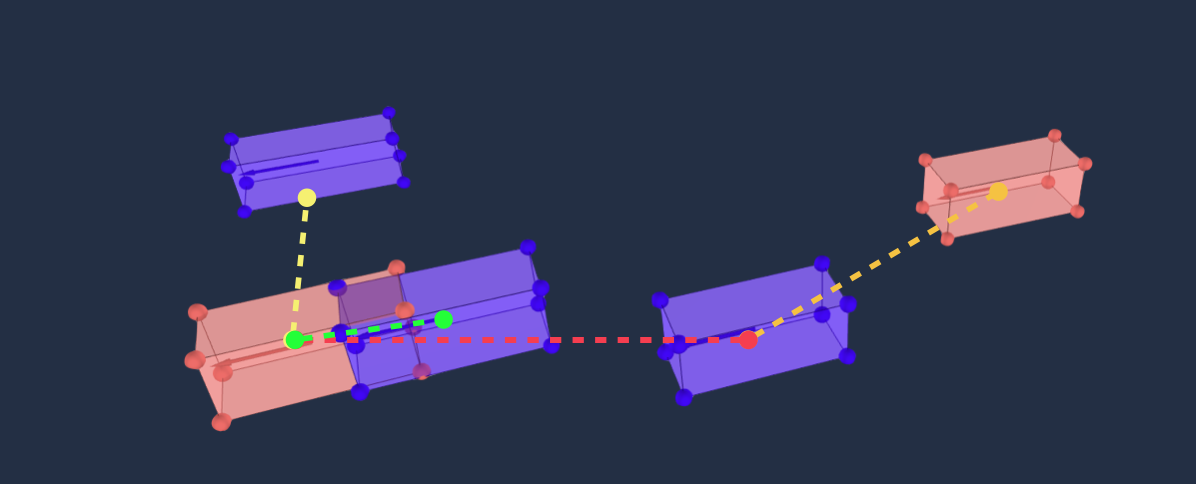

In [ ]:
box1 = boxes_t0[0]
box2 = boxes_t1[0]

In [ ]:
print(box1)
print(box2)

In [ ]:
def centroid_loss(centroid1=None, centroid2=None):
    return np.linalg.norm(centroid1-centroid2)
    #return np.sqrt(np.sum((np.array(centroid1) - np.array(centroid2)) ** 2))

In [ ]:
print(box1[:3])

In [ ]:
print(box2[:3])

In [ ]:
print(centroid_loss(box1[3:6], box2[3:6]))

Now imagine I do something crazy, the value increases.

In [ ]:
print(centroid_loss(box1[3:6], boxes_t0[3][3:6]))

**In 3D, we shouldn't need anything else.** <p>If your 3D projections are correct, there will be no overlap. If we have no overlap, why computing an IOU score? Why doing an orientation error? Why doing a Deep Distance?<p>

My take is, it's not needed, but it could be if a pedestrian is super close to a parked car, and somehow the distance from pedestrian to car is inferior than the distance from car to car.<p>

So let's see the other types of association

#### **2. Orientation Loss**
What if 2 cars are crossing eachother, driving super close, but driving in opposite directions? We can remove that use case using an orientation loss.

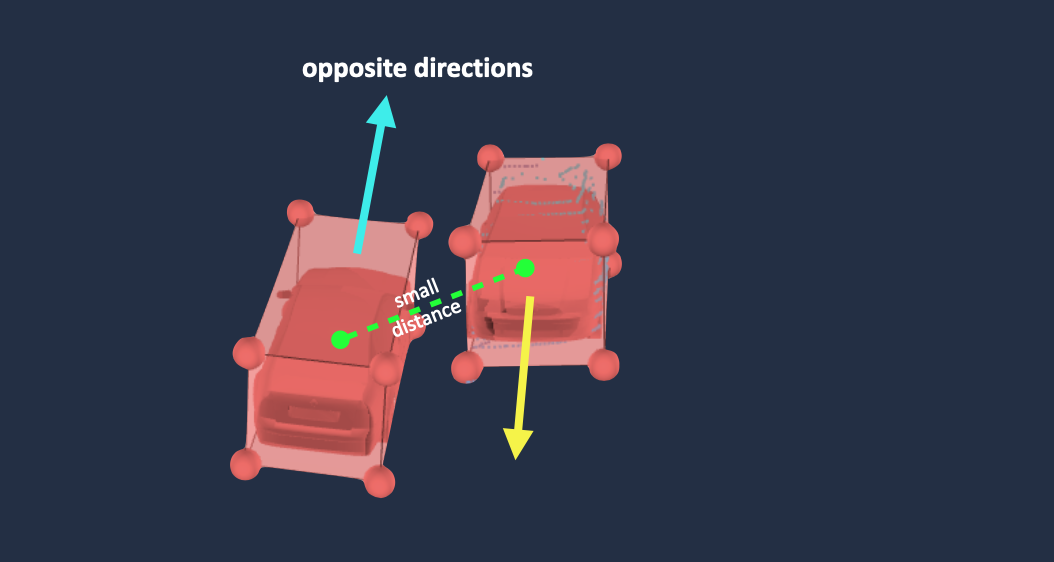

In [ ]:
import math

In [ ]:
def orientation_loss(orientation1=None, orientation2=None):
    return float(1-math.cos(orientation1 - orientation2))

In [ ]:
print(box1[6])
print(box2[0])
print(orientation_loss(box1[6], box2[6]))

Same, now let's do something crazy and look at the loss increasing.

In [ ]:
print(orientation_loss(box1[6], 180))

These 2 losses can work together. We can build a function that does something like:
```python
total_loss = loss_centroid + loss_orientation
```
After all, why not doing it?

#### **3.Chamfer Loss**
The Chamfer Loss gives the distance between two point clouds. It's heavily used in 3D Reconstruction and Point Cloud Alignnment tasks in SLAM. We'll see how it works in Tracking here.
Here's how:
1. We'll grab the points inside each of the boxes
2. We'll run the Chamfer loss over the two point clouds

**If the points structure is the same, then the Chamfer Loss will be small.** If we have a pedestrian and a car, then the loss will increase.

Let's see:

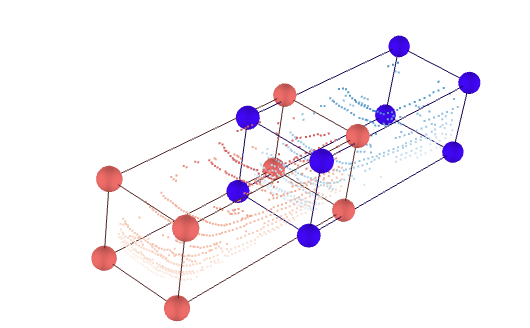

In [ ]:
boxes_t0_original = dataset[hand_picked_frames[0]][4]
boxes_t1_original = dataset[hand_picked_frames[1]][4]

points_t0 = dataset[hand_picked_frames[0]][2]
points_t1 = dataset[hand_picked_frames[1]][2]

**1. Filter the points inside the box**


In [ ]:
print("Box Properties are H W L X Y Z H T")
print(boxes_t0[0])

In [ ]:
def get_bounding(box):
    h, w, l, x, y, z, theta  = box
    x_max = x + l /2
    y_max = y + w /2
    z_max = z + h /2
    x_min = x - l /2
    y_min = y - w /2
    z_min = z - h /2
    return [x_min, y_min, z_min, x_max, y_max, z_max]

In [ ]:
print("Box Properties are H W L X Y Z T")
print(boxes_t0[0])
print(" ")
print("New Properties are X1 Y1 Z1 X2 Y2 Z2")
print(get_bounding(boxes_t0[0]))

In [ ]:
from scipy.spatial import cKDTree

def points_inside_boxes(points, boxes):
    box_points = []
    # Create a KD tree from the points
    tree = cKDTree(points)

    # Find the indices of the points inside each box
    inside_indices = []

    for box in boxes:
        box = get_bounding(box)
        # Find the indices of the points inside the box
        indices = tree.query_ball_point(box[0:3], np.linalg.norm(box[1] - box[3:6], ord=2))
        box_indices = []
        for ind in indices:
            if (points[ind] >= box[:3]).all() and (points[ind] <= box[3:]).all():
                box_indices.append(ind)
        box_points.append(points[box_indices])

    return box_points

points_inside_boxes_t0 = points_inside_boxes(points_t0[:,:3], boxes_t0)

In [ ]:
print([len(points_inside_boxes_t0[i]) for i in range(len(points_inside_boxes_t0))])

In [ ]:
points_inside_boxes_t1 = points_inside_boxes(points_t1[:,:3], boxes_t1)
print([len(points_inside_boxes_t0[i]) for i in range(len(points_inside_boxes_t0))])

**2. Run our chamfer distance**

In [ ]:
!pip install open3d

In [ ]:
import open3d as o3d

In [ ]:
def chamfer_distance_open3d(pts0, pts1):
    pcd0 = o3d.geometry.PointCloud()
    pcd0.points = o3d.utility.Vector3dVector(pts0[:,:3])
    pcd1 = o3d.geometry.PointCloud()
    pcd1.points = o3d.utility.Vector3dVector(pts1[:,:3])
    return pcd0.compute_point_cloud_distance(pcd1)

In [ ]:
dists = chamfer_distance_open3d(points_inside_boxes_t0[0], points_inside_boxes_t1[0])
print("Distance:" , sum(dists))

**3. Compare Visually**

In [ ]:
all_pts0 = np.concatenate(points_inside_boxes_t0, axis=0)
all_pts1 = np.concatenate(points_inside_boxes_t1, axis=0)

In [ ]:
print(len(all_pts0))
print(len(all_pts1))

In [ ]:
print(all_pts0)
print("---")
print(points)

In [ ]:
#If you need to restart the visualizer, remove the frames stored
shutil.rmtree('frames', ignore_errors=True)
shutil.rmtree("3dframes", ignore_errors= True)

In [ ]:
from vedo import *   # For some reason, this needs to be imported everytime you need to run this cell or else it wil crash. very important!
settings.default_backend = 'ipyvtk'

vi = Viewer(box_type="Kitti")

vi.add_points(all_pts0,
                radius = 2,
                color = "blue",
                scatter_filed = all_pts0[:,2],
                alpha=1,
                del_after_show = True,
                add_to_3D_scene = True,
                add_to_2D_scene = False,
                color_map_name ="Blues")

vi.add_points(all_pts1,
                radius = 2,
                color = "red",
                scatter_filed = all_pts1[:,2],
                alpha=1,
                del_after_show = True,
                add_to_3D_scene = True,
                add_to_2D_scene = False,color_map_name="Reds")

vi.add_3D_boxes(boxes_t0_original,
                color="blue",
                add_to_3D_scene=True, mesh_alpha = 0, show_corner_spheres = True,
                corner_spheres_alpha = 1, corner_spheres_radius=0.2,
                show_heading = False, heading_scale = 1, show_lines = True,
                line_width = 3, line_alpha = 1,
                show_ids = False, show_box_info=True, del_after_show=True,
                add_to_2D_scene=True, caption_size=(0.09,0.09))

vi.add_3D_boxes(boxes_t1_original, color="red",
                add_to_3D_scene=True, mesh_alpha = 0, show_corner_spheres = True,
                corner_spheres_alpha = 1, corner_spheres_radius=0.2,
                show_heading = False, heading_scale = 1, show_lines = True,
                line_width = 3, line_alpha = 1,
                show_ids = False, show_box_info=True, del_after_show=True,
                add_to_2D_scene=True, caption_size=(0.09,0.09))

vi.add_image(image)
vi.set_extrinsic_mat(V2C)
vi.set_intrinsic_mat(P2)
vi.show_3D(1, True)

In [ ]:
%show_interactive_plots

#### **Get the Total Geometric Cost**

In [ ]:
def geometric_cost(box1, box2, w1=1,w2=1,w3=1):
    return w1*euclidean_distance(box1, box2) + w2*orientation_distance(box1,box2) + w3*chamfer_distance(box1, box2)

#### **4. 3D IOU**
In 2D, the most common metric ever for tracking or fusion is the Intersection Over Union. Although this is a good enough metric in 2D (and I would argue it's definitely not enough — see my MOT course for details), I think this metric is overkill for 3D cases. <p>
Most importantly, it requires the computation of volumes, which can be computationaly ineffective.<p>
Let's see how it's done anyway.

In [ ]:
def iou_3d(box1, box2):
    print("Format is H W L X Y Z T")
    print("Box 1: ", list(box1))
    print("Box 2: ", list(box2))
    boxA = get_bounding(box1)
    boxB = get_bounding(box2)
    print("Format is now: X1 Y1 Z1 X2 Y2 Z2")
    print("Box A: ", boxA)
    print("Box B: ", boxB)

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    zA = max(boxA[2], boxB[2])

    xB = min(boxA[3], boxB[3])
    yB = min(boxA[4], boxB[4])
    zB = min(boxA[5], boxB[5])

    inter = max(0, xB - xA) * max(0, yB -yA) * max(0,zB - zA)
    print("Intersection: ", inter)

    volA = box1[0] * box1[1] * box1[2]
    print("Volume A: ", volA)

    volB = box2[0] * box2[1] * box2[2]
    print("Volume B: ", volB)

    iou = inter / float(volA + volB - inter)
    print("Final IOU:", iou)
    return iou

In [ ]:
iou_3d(boxes_t0[0], boxes_t1[0])

In [ ]:
import time

t0 = time.time()
print(iou_3d(box1, box2))
t1 = time.time()
print("Time to compute: ", t1 - t0, "seconds")
print("For 10 obstacles per frame, it would mean: ", (t1 - t0) * 100, "seconds")